In [1]:
# CAP6629 001 RL Spring 2023
# Yiran Pang
# Copied and adapted from https://www.samyzaf.com/ML/rl/qmaze.html about Maze Definition Part

In [2]:
import os, sys, time, datetime, json, random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

- 0 - 左
- 1 - 向上
- 2 - 右
- 3 - 向下
- 每次移动都会花费老鼠 -0.04 分
- 奶酪，给予 1.0 分
- 封锁的单元格-0.75 分，动作不会被执行
- 已经访问过的单元格，-0.25 分
- 总奖励低于负阈值：(-0.5 * maze.size)，lose

In [3]:
visited_mark = 0.8  # Cells visited by the rat will be painted by gray 0.8
rat_mark = 0.5      # The current rat cell will be painteg by gray 0.5
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)

# Exploration factor
epsilon = 0.1

## Q-maze

In [91]:
# maze is a 2d Numpy array of floats between 0.0 to 1.0
# 1.0 corresponds to a free cell, and 0.0 an occupied cell
# rat = (row, col) initial rat position (defaults to (0,0))

class Qmaze(object):
    def __init__(self, maze, rat=(0,0)):
        # 初始化迷宫，老鼠可以从任意位置开始，默认为左上角
        self._maze = np.array(maze)
        nrows, ncols = self._maze.shape
        # 终点始终在右下角
        self.target = (nrows-1, ncols-1)   # target cell where the "cheese" is
        # 初始化空格list，maze为1表示空格，为0表示墙体
        self.free_cells = [(r,c) for r in range(nrows) for c in range(ncols) if self._maze[r,c] == 1.0]
        # 将目标格移出空格list
        self.free_cells.remove(self.target)
        # 检查左上和右下是否为空
        if self._maze[self.target] == 0.0:
            raise Exception("Invalid maze: target cell cannot be blocked!")
        if not rat in self.free_cells:
            raise Exception("Invalid Rat Location: must sit on a free cell")
        # 放置老鼠并初始化参数
        self.reset(rat)

    def reset(self, rat):
        self.rat = rat
        self.maze = np.copy(self._maze)
        nrows, ncols = self.maze.shape
        row, col = rat
        self.maze[row, col] = rat_mark
        # 初始状态
        self.state = (row, col, 'start')
        # 设置最低奖励阈值
        self.min_reward = -800
        # 初始化总奖励
        self.total_reward = 0
        self.visited = set()

    def update_state(self, action):
        '''
            input: action [0, 1, 2, 3] [L, U, R, D]
        '''
        nrows, ncols = self.maze.shape
        nrow, ncol, nmode = rat_row, rat_col, mode = self.state
        
        # 如果老鼠访问的是空格，则记录
        if self.maze[rat_row, rat_col] > 0.0:
            self.visited.add((rat_row, rat_col))  # mark visited cell

        # 获取所有可能执行的动作
        valid_actions = self.valid_actions()
        # print('valid_actions', valid_actions)
        
        # 如果没有可以执行的动作（被围住了），则状态为 blocked，位置不变
        if not valid_actions:
            nmode = 'blocked'
        # 如果需要执行的动作在可执行动作列表中，那么状态为有效，并相应执行动作
        elif action in valid_actions:
            nmode = 'valid'
            if action == LEFT:
                ncol -= 1
            elif action == UP:
                nrow -= 1
            if action == RIGHT:
                ncol += 1
            elif action == DOWN:
                nrow += 1
        # 如果需要执行的动作不在可执行动作列表中（撞墙），位置不变
        else:                  # invalid action, no change in rat position
            nmode = 'invalid'

        # new state
        self.state = (nrow, ncol, nmode)

    def get_reward(self):
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 1.0  # 奶酪，给予 1.0 分
        if mode == 'blocked':
            return self.min_reward - 1
        if (rat_row, rat_col) in self.visited:
            return -0.25  # 访问已经访问过的单元格，-0.25 分
        if mode == 'invalid':
            return -0.75  # 撞墙-0.75 分，动作不会被执行
        if mode == 'valid':
            return 0  # 每次移动都会花费老鼠 -0.04 分

    def act(self, action):
        self.update_state(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.maze)
        nrows, ncols = self.maze.shape
        # clear all visual marks
        for r in range(nrows):
            for c in range(ncols):
                if canvas[r,c] > 0.0:
                    canvas[r,c] = 1.0
        # draw the rat
        row, col, valid = self.state
        canvas[row, col] = rat_mark
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        rat_row, rat_col, mode = self.state
        nrows, ncols = self.maze.shape
        if rat_row == nrows-1 and rat_col == ncols-1:
            return 'win'

        return 'not_over'

    def valid_actions(self, cell=None):
        # 默认验证当前位置
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        nrows, ncols = self.maze.shape
        # 如果在第0行，则不能向上走；如果在最后一行，则不能向下走
        if row == 0:
            actions.remove(1)
        elif row == nrows-1:
            actions.remove(3)
        # 列-左右
        if col == 0:
            actions.remove(0)
        elif col == ncols-1:
            actions.remove(2)

        # 如果不在最左列，而左边是墙，则不能向左；右边同理
        if row>0 and self.maze[row-1,col] == 0.0:
            actions.remove(1)
        if row<nrows-1 and self.maze[row+1,col] == 0.0:
            actions.remove(3)

        # 上下同理
        if col>0 and self.maze[row,col-1] == 0.0:
            actions.remove(0)
        if col<ncols-1 and self.maze[row,col+1] == 0.0:
            actions.remove(2)

        # 返回所有可能执行的动作
        return actions

In [92]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    rat_row, rat_col, _ = qmaze.state
    canvas[rat_row, rat_col] = 0.3   # rat cell
    canvas[nrows-1, ncols-1] = 0.9 # cheese cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

In [93]:
maze = [
    [ 1.,  1., 1., 1.],
    [ 1.,  1., 0., 1.],
    [ 1.,  1., 1., 1.],
    [ 1.,  1., 1., 1.],
]
# maze = np.loadtxt('games/GridWorld/maze8_0.1_2.txt')

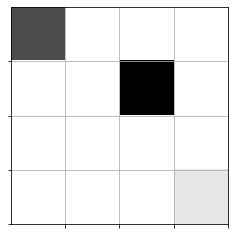

In [94]:
qmaze = Qmaze(maze)
# canvas, reward, game_over = qmaze.act(DOWN)
# print("reward=", reward)
show(qmaze)

0 0
0 0
-0.25 -0.25 not_over


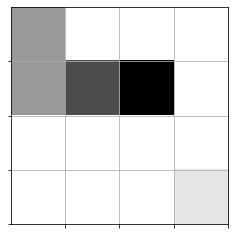

In [95]:
envstate, reward, status = qmaze.act(DOWN)  # move down
print(reward, qmaze.total_reward)
envstate, reward, status = qmaze.act(RIGHT)  # move right
print(reward, qmaze.total_reward)
envstate, reward, status = qmaze.act(RIGHT)  # move right
print(reward, qmaze.total_reward, status)
# envstate, reward, status = qmaze.act(RIGHT)  # move right
# print(reward, qmaze.total_reward)
# envstate, reward, status = qmaze.act(UP)  # move up
# print(reward, qmaze.total_reward)
show(qmaze)

## Q-Learning

0 - 左
1 - 向上
2 - 右
3 - 向下

$$Q(s,a)= Q(s, a) + α⋅[Value(s’)+γ⋅maxQ(s′)−Q(s,a)]$$

**Pseudocode**
```
Init Q(s, a) to 0 for all (s, a) pairs
Repeat for episode = 1 ... numEpisodes
     Initialize s to startState
     While (s is not TerminalState)
           Choose an action a from Actions(s)
           s' = new state after action a from s
           Q(s,a)= Q(s, a) + α⋅[Value(s’)+γ⋅maxQ(s′)−Q(s,a)]
           s = s'
```

In [64]:
# 定义参数
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99
NUM_Episodes = 10
MAZE_SIZE = qmaze.maze.shape[0]

# 将状态表示为一个数字
def state_to_index(state):
    return state[0] * MAZE_SIZE + state[1]

# 获取当前状态下的最佳行动
def get_best_action(rat_row, rat_col):
    state = (rat_row, rat_col)
    index = state_to_index(state)
    return np.argmax(q_table[index])

# 通过ε-greedy策略选择下一个行动
def choose_action(state, epsilon):
    if np.random.uniform() < epsilon:
        return np.random.randint(4)
    else:
        return get_best_action(*state)
    
# 更新 Q 表格
def update_q_table(state, action, next_state, reward):
    index = state_to_index(state)
    next_index = state_to_index(next_state)
    q_table[index][action] += LEARNING_RATE * (
        reward + DISCOUNT_FACTOR * np.max(q_table[next_index]) - q_table[index][action])

    
# Q-Table
# 每行代表格子，从上往下从左往右
# 每列代表动作，0 - 左 1 - 向上 2 - 右 3 - 向下
q_table = np.zeros((qmaze.maze.shape[0]**2, 4))  
total_reward = []

for episode in range(NUM_Episodes):
    epsilon = 1.0 / (episode + 1)
    
    qmaze = Qmaze(maze)
    
    while qmaze.game_status() == 'not_over':
        # 初次观测
        rat_row, rat_col, mode = qmaze.state
        # 选择动作
        # print(rat_row, rat_col, mode)
        action = choose_action((rat_row, rat_col), epsilon)
        # print(action)
        # 执行动作并二次观测
        canvas, reward, game_over = qmaze.act(action)
        rat_row_next, rat_col_next, mode = qmaze.state
        # 根据观测更新Q
        update_q_table((rat_row, rat_col), action, (rat_row_next, rat_col_next), reward)
    
    print('============episode:', episode, '============')
    print(q_table)
    print('total_reward', qmaze.total_reward)
    total_reward.append(qmaze.total_reward)
    print('')

============episode: 0 ============
[[ 0.       0.       0.       0.     ]
 [ 0.      -0.075    0.       0.     ]
 [ 0.       0.       0.      -0.075  ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.      -0.075    0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.      -0.20325  0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.       0.     ]
 [ 0.       0.       0.1      0.     ]
 [ 0.       0.       0.       0.     ]]
total_reward -3.5

============episode: 1 ============
[[-0.74928375 -0.7479458   0.          0.        ]
 [ 0.         -0.7479458   0.          0.        ]
 [ 0.         -0.42714959  0.         -0.39127733]
 [ 0.         -0.075      -0.1425      0.        ]
 [-0.55936006  0.          0.          0.        ]
 [ 0.          0.         -0.

In [47]:
q_value_table = np.amax(q_table, axis=1).reshape((8, 8))
print('q_value_table')
print(q_value_table)

q_value_table
[[0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.1]
 [0.  0.  0.  0.  0.  0.  0.  0. ]]


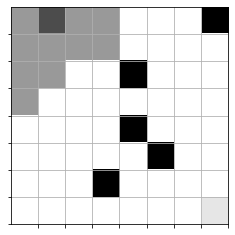

In [48]:
show(qmaze)

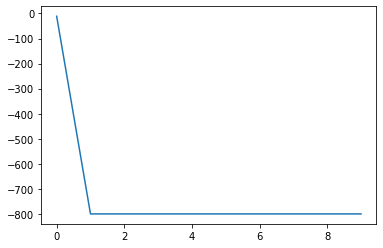

In [49]:
%matplotlib inline
plt.plot(total_reward)
plt.show()

## Monte Carlo

**Pseudocode**
```
Initialize state-action value function Q(s, a)
Initialize sampling counter N(s, a)
for episode in episodes:
    Generate an episode and record information for each state-action pair
    G = 0
    for t in reversed(range(0, episode_length)):
        S_t, A_t, R_t = episode[t]
        G = gamma * G + R_t
        N(S_t, A_t) += 1
        alpha = 1 / N(S_t, A_t)
        Q(S_t, A_t) += alpha * (G - Q(S_t, A_t))
return state-action value function Q
```

In [105]:
from tqdm import trange
import math

# 定义参数
LEARNING_RATE = 0.1
DISCOUNT_FACTOR = 0.99
NUM_Episodes = 500
MAZE_SIZE = qmaze.maze.shape[0]
records = []
q_table = np.zeros((qmaze.maze.shape[0]**2, 4))
EPS_START = 0.95
EPS_END = 0.05
EPS_DECAY = 10000
epsilon = EPS_START
steps_done = 0

# 将状态表示为一个数字
def state_to_index(state):
    return state[0] * MAZE_SIZE + state[1]

# 获取当前状态下的最佳行动
def get_best_action(rat_row, rat_col):
    state = (rat_row, rat_col)
    index = state_to_index(state)
    return np.argmax(q_table[index])

# 通过ε-greedy策略选择下一个行动
def choose_action(state, epsilon):
    if np.random.uniform() < epsilon:
        return np.random.randint(4)
    else:
        return get_best_action(*state)
    
# 更新 Q 表格
# def update_q_table(state, action, next_state, reward):
#     index = state_to_index(state)
#     next_index = state_to_index(next_state)
#     q_table[index][action] += LEARNING_RATE * (
#         reward + DISCOUNT_FACTOR * np.max(q_table[next_index]) - q_table[index][action])

    
# Q-Table
# 每行代表格子，从上往下从左往右
# 每列代表动作，0 - 左 1 - 向上 2 - 右 3 - 向下
Q = q_table  # 初始化状态-动作价值函数
N = np.zeros((qmaze.maze.shape[0]**2, 4))  # 记录每个状态-动作被采样的次数
total_reward = []

for episode in trange(NUM_Episodes):
    
    
    qmaze = Qmaze(maze)
    
    # 进行一次完整的 episode，并记录每个状态-动作的信息
    while qmaze.game_status() == 'not_over':
        # 初次观测
        rat_row, rat_col, mode = qmaze.state
        # 选择动作
        # print(rat_row, rat_col, mode)
        action = choose_action((rat_row, rat_col), epsilon)

        state, action = state_to_index((rat_row, rat_col)), action

        # 执行动作并二次观测
        canvas, reward, game_over = qmaze.act(action)

        records.append((state, action, reward))

        rat_row_next, rat_col_next, mode = qmaze.state
        
        # 随着进行，eps_threshold逐渐降低
        epsilon = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        
        steps_done += 1
        

    
    # 使用经验采样更新状态-动作价值函数
    G = 0  # 记录返回值
    for j in range(len(records)-1, -1, -1):
        state, action, reward = records[j]
        G += reward
        N[state][action] += 1
        alpha = 1 / N[state][action]
        Q[state][action] += alpha * (G - Q[state][action])
        
    # # 根据观测更新Q
    # update_q_table((rat_row, rat_col), action, (rat_row_next, rat_col_next), reward)
    
    # print('============episode:', episode, '============')
    # print(Q)
    # print('total_reward', qmaze.total_reward)
    total_reward.append(qmaze.total_reward)
    # print('')
    
    # break

100%|██████████| 500/500 [01:56<00:00,  4.29it/s]


In [106]:
q_value_table

array([[-2068.83849119, -1968.51239294, -2071.5773681 , -2017.06366643],
       [-2108.90947182, -2100.50911976,     0.        , -1987.13184729],
       [-2018.16874244, -2101.96552115, -2156.60846569, -2080.36302301],
       [-2041.22666548, -2099.80097838, -2129.00140609,     0.        ]])

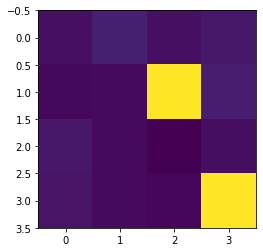

In [107]:
plt.imshow(q_value_table)

In [108]:
q_value_table = np.amax(Q, axis=1).reshape((4, 4))
print('q_value_table')
print(q_value_table)

q_value_table
[[-17581.91288214 -16760.70526882 -12952.13975174 -11585.04661036]
 [-16125.21122935 -20018.17397748      0.         -11120.89338989]
 [-11689.85131049 -12824.00736908 -11420.12091368 -11186.8574567 ]
 [-16528.8818896  -11827.62549647 -11609.24123099      0.        ]]


In [109]:
Q 

array([[-20582.8008399 , -20587.15756488, -20045.26996973,
        -17581.91288214],
       [-20378.06148324, -16760.70526882, -20389.20482477,
        -20020.26809669],
       [-20149.49146338, -19086.98419543, -19002.80848833,
        -12952.13975174],
       [-18107.99445939, -11585.04661036, -15792.54632639,
        -15959.92037387],
       [-20436.20562614, -19992.47181655, -20527.17112541,
        -16125.21122935],
       [-20018.17397748, -20430.86199758, -20651.11755636,
        -20613.02411432],
       [     0.        ,      0.        ,      0.        ,
             0.        ],
       [-11120.89338989, -14532.07779896, -15655.42304476,
        -14367.911244  ],
       [-11689.85131049, -16217.9017773 , -16264.64305633,
        -19227.8817151 ],
       [-19803.31133576, -20520.13023687, -12824.00736908,
        -19681.82050065],
       [-12716.52977512, -11420.12091368, -12534.8727911 ,
        -14154.27913052],
       [-13988.53321777, -12674.52594372, -11186.8574567 ,
      

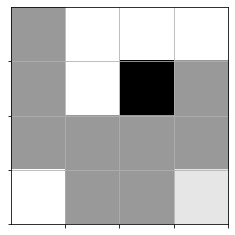

In [110]:
show(qmaze)

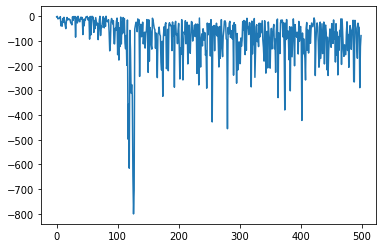

In [111]:
%matplotlib inline
plt.plot(total_reward)
plt.show()

In [112]:
# Q = q_table  # 初始化状态-动作价值函数
# N = np.zeros((qmaze.maze.shape[0]**2, 4))  # 记录每个状态-动作被采样的次数
# total_reward = []
records = []

# # 通过ε-greedy策略选择下一个行动
# def choose_action(state, epsilon):
#     if np.random.uniform() < epsilon:
#         return np.random.randint(4)
#     else:
#         return get_best_action(*state)

for episode in trange(1):
    
    
    qmaze = Qmaze(maze)
    
    # 进行一次完整的 episode，并记录每个状态-动作的信息
    while qmaze.game_status() == 'not_over':
        # 初次观测
        rat_row, rat_col, mode = qmaze.state
        # 选择动作
        # print(rat_row, rat_col, mode)
        action = get_best_action(rat_row, rat_col)

        state, action = state_to_index((rat_row, rat_col)), action

        # 执行动作并二次观测
        canvas, reward, game_over = qmaze.act(action)

        records.append((state, action, reward))

        rat_row_next, rat_col_next, mode = qmaze.state
        
        # 随着进行，eps_threshold逐渐降低
        epsilon = EPS_END + (EPS_START - EPS_END) * \
            math.exp(-1. * steps_done / EPS_DECAY)
        
        steps_done += 1
        

    
    # 使用经验采样更新状态-动作价值函数
#     G = 0  # 记录返回值
#     for j in range(len(records)-1, -1, -1):
#         state, action, reward = records[j]
#         G += reward
#         N[state][action] += 1
#         alpha = 1 / N[state][action]
#         Q[state][action] += alpha * (G - Q[state][action])
        
    # # 根据观测更新Q
    # update_q_table((rat_row, rat_col), action, (rat_row_next, rat_col_next), reward)
    
    # print('============episode:', episode, '============')
    # print(Q)
    # print('total_reward', qmaze.total_reward)
    total_reward.append(qmaze.total_reward)

100%|██████████| 1/1 [00:00<00:00,  7.97it/s]


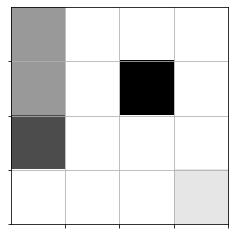

In [113]:
show(qmaze)